# Multiplicity figure

In [1]:
from collections import defaultdict, Counter
import pandas as pd
from scipy import stats as sci_stats
from matplotlib import pyplot as pl
from matplotlib import cm
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, to_rgba
from statsmodels.stats.multitest import fdrcorrection as benjamini_hochberg
from matplotlib.patches import Rectangle

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
plates = ['P1', 'P2', 'P3']
plate2env = {'P1': r'YPD 30$\degree$C', 'P2': r'SC 30$\degree$C', 'P3': r'SC 37$\degree$C'}
strains = ['diploid', 'alpha', 'a']
strains_for_print = {'a': '$MATa$', 'diploid': 'Diploid', 'alpha': r'$MAT\alpha$'}
color_by_strain = {'diploid': '#555555', 'alpha': '#FFB000', 'a': '#648FFF'}
fa_gens = [70, 550, 1410, 2640, 3630, 5150, 7530, 10150]
seq_gens = [70, 1410, 2640, 5150, 7530, 10150]
all_wells = sorted([i.split('/')[-1].split('_')[0] for i in glob('../../Output/WGS/combined_option/processed_well_output/*_processed.tsv')])
wells = [w for w in all_wells if w!='P1B03'] #P1B03 excluded because it is a haploid population that diploidized
gene_info = pd.read_csv('../accessory_files/yeast_gene_annotations.tsv', delimiter='\t')
gene_info = gene_info[gene_info['featureType']=='ORF'].loc[gene_info['briefDescription'].apply(lambda bd: ('Putative protein' not in bd) and ('Dubious open reading frame' not in bd))]
gene_to_start_end = {i[0]: i[1:] for i in gene_info.as_matrix(['Gene_ORF', 'start', 'end'])}
orf_sizes = list(gene_info['end']-gene_info['start'])

essential_orfs_by_Liu = list(gene_info[gene_info['Essential_by_Liu2015']]['ORF'])
essential_orfs_by_Gaiever_not_Liu = [i for i in gene_info[gene_info['Essential_by_Giaever2002']]['ORF'] if i not in essential_orfs_by_Liu]

o2g = {i[0]:i[1] for i in gene_info.as_matrix(['ORF', 'Gene_ORF']) if pd.notnull(i[1])}
o2g.update({i[0]:i[0] for i in gene_info.as_matrix(['ORF', 'Gene_ORF']) if pd.isnull(i[1])})
g2o = {o2g[o]:o for o in o2g}
wellinfo = pd.read_csv('../accessory_files/VLTE_by_well_info.csv')[['plate.well', 'contam', 'strain']]
wellinfo['plate_well'] = wellinfo['plate.well'].apply(lambda p: p[:2]+p[3:]) #reformatting to match for merge
well_to_strain = {i[0]:i[1] for i in wellinfo.as_matrix(['plate_well', 'strain'])}
wells_w_ade2_stop_lost = ['P2F07', 'P1C09', 'P1E11', 'P3B10', 'P2B09']
cb_pal = sns.color_palette('colorblind')

## Loading mutation data for next figures

## Some code for calculating mutational opportunities:

In [3]:
nt2codon = {
    'TTT': 'F', 'TTC': 'F',
    'TTA': 'L', 'TTG': 'L', 'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S', 'AGT': 'S', 'AGC': 'S',
    'TAT': 'Y', 'TAC': 'Y',
    'TAA': '*', 'TAG': '*', 'TGA': '*',
    'TGT': 'C', 'TGC': 'C',
    'TGG': 'W',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H',
    'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R', 'AGA': 'R', 'AGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I',
    'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N',
    'AAA': 'K', 'AAG': 'K',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D',
    'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

def get_attrib(row, attrib):
    if row['type']=='gene':
        if attrib+'=' in row['attributes']:
            return row['attributes'].split(attrib+'=')[1].split(';')[0]
    return ''

def read_fasta(fasta_file):
    """
    Reads a fasta file and returns a dictionary with seqid keys and sequence values
    """
    fd = dict()
    with open(fasta_file, 'r') as infile:
        for line in infile:
            if '>' in line:
                current_key = line[1:].strip()
                fd[current_key] = ''
            else:
                fd[current_key] += line.strip()
    return fd

def reverse_transcribe(seq):
    """reverse transcribes a dna sequence (does not convert any non-atcg/ATCG characters)"""
    watson_crick = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'a': 't', 't': 'a', 'g': 'c', 'c': 'g'}
    return ''.join([watson_crick.setdefault(c, c) for c in seq[::-1]])

class SeqInfoGetter:
    
    def __init__(self, gff_file, fasta_file):
        gff_cols = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
        self.gff = pd.read_csv(gff_file, delimiter='\t', skiprows=1, header=None, names=gff_cols)
        self.gff['ORF'] = self.gff.apply(lambda row: get_attrib(row, "ID"), axis=1)
        self.genes = self.gff[self.gff['ORF']!='']
        self.genes['Gene'] = self.genes.apply(lambda row: get_attrib(row, "gene"), axis=1)
        self.chromo_seqs = read_fasta(fasta_file)
    
    def get_nt_seq(self, element_name, element_type):
        td = self.genes[self.genes[element_type]==element_name]
        if len(td) != 1:
            print(len(td), 'hits, aborting.')
            return None
        else:
            row = td.iloc[0]
            cs = self.chromo_seqs[row['seqid']]
            if row['strand'] == '+':
                return cs[row['start']-1:row['end']]
            else:
                return reverse_transcribe(cs[row['start']-1:row['end']])
            
    def get_aa_seq(self, element_name, element_type):
        nt_s = self.get_nt_seq(element_name, element_type)
        if nt_s:
            aas = ''
            for i in range(len(nt_s)//3):
                aas += nt2codon[nt_s[i*3:(i+1)*3]]
            if len(nt_s) % 3 != 0:
                aas += '-leftover->' + nt_s[-1*(len(nt_s) % 3):]
            return aas
            
    def get_mutational_opps(self, element_name, element_type, verbose=False, return_nonsyn_over_all=False):
        nt_s = self.get_nt_seq(element_name, element_type)
        if nt_s:
            if len(nt_s) % 3 != 0:
                if verbose:
                    print('Warning: seq len not a multiple of 3', element_name)
                    print(self.genes[self.genes[element_type]==element_name].iloc[0]['Gene'])
                    print(self.get_aa_seq(element_name, element_type))
           
            syn, nonsyn = 0, 0
            for i in range(len(nt_s)//3):
                codon_seq = nt_s[i*3:(i+1)*3]
                codes_for = nt2codon[codon_seq]
                for j in range(3):
                    for nt in 'ATCG':
                        if nt != codon_seq[j]:
                            if nt2codon[codon_seq[:j]+nt+codon_seq[j+1:]] == codes_for:
                                syn += 1
                            else:
                                nonsyn += 1
            if return_nonsyn_over_all:
                return nonsyn/(syn+nonsyn)
            else:
                return nonsyn / syn

In [4]:
seqI = SeqInfoGetter('../../Output/WGS/reference/w303_vlte.gff', '../../Output/WGS/reference/w303_vlte.fasta')

In [5]:
orf_lens = {o: len(seqI.get_nt_seq(o, "ORF")) for o in seqI.genes['ORF']}
orf_mutational_opp_ratios = {o: seqI.get_mutational_opps(o, "ORF") for o in seqI.genes['ORF']} # Yeilds % of nonsyn/syn random mutations in each ORF
orf_mutational_nonsyn_opps = {o: seqI.get_mutational_opps(o, "ORF", return_nonsyn_over_all=True)*orf_lens[o] for o in seqI.genes['ORF']} # Yeilds % of nonsyn/syn random mutations in each ORF
total_len = np.sum(list(orf_lens.values()))
total_nonsyn_ratio = np.sum([orf_mutational_opp_ratios[o]*orf_lens[o]/total_len for o in orf_lens])
total_nonsyn_ratio

3.70897210627441

In [6]:
def is_snp(row):
    if row['mutation_type'] != 'Indel':
        # * is given if there is a spanning deletion at this site (so no counts for ref or alt (not a SNP)))
        if len(row['REF']) == 1 and len(row['ALT'])==1 and row['ALT'] != '*': 
            return True
    return False
 
def hit_orfs(orf_list, search_list):
    for o in str(orf_list).split(';'):
        if o in search_list:
            return True
    return False

# by well dataframes with mutations
well_dats = dict()
for well in wells:
    well_dats[well] = pd.read_csv('../../Output/WGS/combined_option/processed_well_output/' + well + '_processed.tsv', delimiter='\t')
    # Exclude from analysis mutations in the 2-micron plasmid and telomeres, and SVs
    well_dats[well] = well_dats[well][pd.isnull(well_dats[well]['SVTYPE']) & (well_dats[well]['CHROM']!='2-micron') & (~well_dats[well]['in_telomere'])]
    well_dats[well]['is_snp'] = well_dats[well].apply(lambda r: is_snp(r), axis=1)

# a dataframe with hits and multiplicity for each ORF in the yeast genome
orf_hit_df = pd.read_csv('../../Output/WGS/combined_option/gene_hit_data.tsv', delimiter='\t')
orf_hit_df = orf_hit_df.merge(gene_info[['ORF', 'briefDescription', 'Essential_by_Liu2015', 'Essential_by_Giaever2002', 'start', 'end']], on='ORF', how='left')


# Multiplicity fig

In [7]:
# getting how many times each amino acid position is hit
# for now just taking the first annotation from the ANN column: 
# when split by |, the 14th column is the codon position like 54/109
aa_hits = defaultdict(set)
for well in wells:
    td = well_dats[well]
    mgs_seen = set()
    for entry in td[td['fixed_by_10150'] & pd.notnull(td['ORF_hit'])].as_matrix(['ANN', 'ORF_hit', 'mutation_type', 'CHROM', 'POS', 'REF', 'ALT', 'mutation_group']):
        if entry[7] not in mgs_seen:
            mgs_seen.add(entry[7])
            aa_pos_split = str(entry[0]).split('|')
            if len(aa_pos_split) > 13:
                if aa_pos_split[13] != '':
                    aa_hits[entry[1]+'_'+aa_pos_split[13]].add(well+' '+str(entry[2])+' '+str(entry[3])+' '+str(entry[4])+' ' + '->'.join(entry[5:7]) + ' '+ aa_pos_split[10])

In [8]:
# Simulating multiplicity by drawing genes to hit for each population,
# taking into account the number of hit mutations in each population,
# and the lengths of all ORFs in the yeast genome
def simulate_gene_hits(well_num_hits, nsamps=1000):
    all_m_opps = list(orf_mutational_nonsyn_opps.values())
    orf_hits = [0 for o in all_m_opps]
    mean_opps = np.mean(all_m_opps)
    orf_hit_probs = np.array(all_m_opps)/np.sum(all_m_opps)
    multiplicities = []
    pops_hit = []
    for n in range(nsamps):
        hit_table = []
        for num_hits in well_num_hits:
            hit_table.append(np.random.multinomial(num_hits, orf_hit_probs))
        hit_table = np.array(hit_table)
        orf_hits = np.sum(hit_table, axis=0)
        multiplicities += [mult for mult in list(mean_opps * (orf_hits / np.array(all_m_opps))) if mult != 0] # we do not include orfs with zero hits
        pops_hit += list(np.sum(np.clip(hit_table, 0, 1), axis=0))
    return multiplicities, pops_hit

pop_hits = np.sum(orf_hit_df[wells], axis=0)
sim_mult, sim_hits = simulate_gene_hits(pop_hits)

pop_hits = np.sum(orf_hit_df[wells], axis=0)
sim_mult, sim_hits = simulate_gene_hits(pop_hits)


In [9]:
def simulate_aa_pos_hits(nsamps=100):
    ## What I want to do is actually look at the ORFs that are hit and randomize which codon they hit
    pops_hit = []
    for n in range(nsamps):
        aa_sim_hits_dict = defaultdict(set)
        for well in wells:
            for entry in np.array(orf_hit_df[['ORF', 'size', well]]):
                for i in range(entry[2]):
                    aa_sim_hits_dict[entry[0]+'_'+str(np.random.randint(entry[1]))].add(well)
        pops_hit += [len(i) for i in aa_sim_hits_dict.values()]
    return pops_hit

sim_aa_hits = simulate_aa_pos_hits()
sim_aa_hits += [0]*(np.sum(list(orf_lens.values()))//3-len(sim_aa_hits))

Prob of getting 5 pop hits or more: 0.04367244262045904
Prob of getting 6 pop hits or more: 0.021868825049399604
Prob of getting 7 pop hits or more: 0.011154582763337893


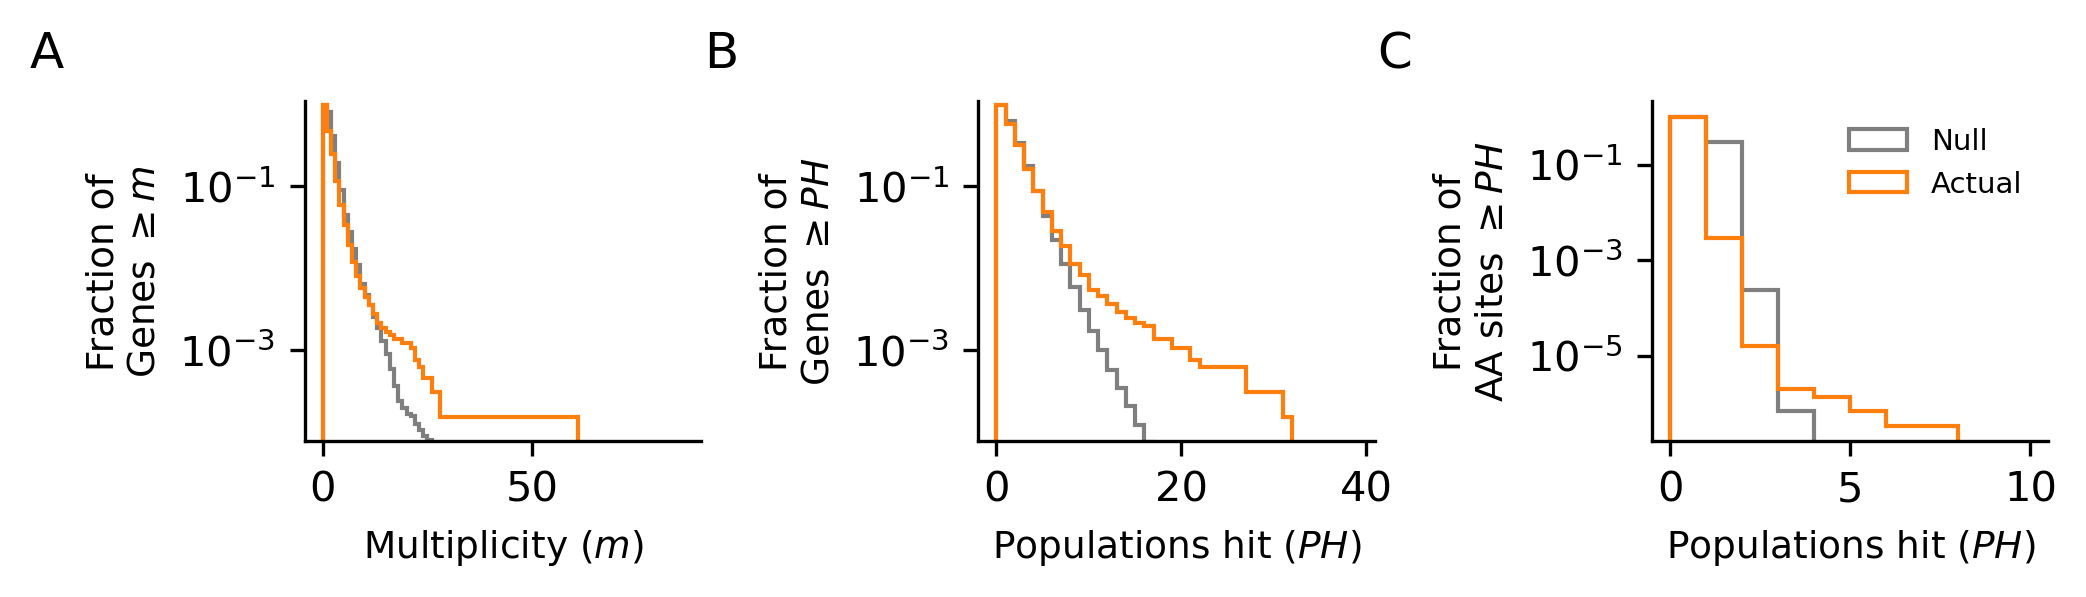

In [10]:
f, subs = pl.subplots(1, 3, figsize=(7.5, 1.5), dpi=300)
pl.subplots_adjust(wspace=0.7)

actual_mult = list(orf_hit_df['multiplicity'])
actual_mult += [0]*(len(orf_lens)-len(orf_hit_df))
max_m = int(np.ceil(max(actual_mult)))
subs[0].hist(sim_mult, histtype='step', log=True, bins=[i for i in range(max_m)], cumulative=-1, edgecolor='k', alpha=0.5, label='Null', 
         weights=np.ones_like(sim_mult)/float(len(sim_mult)))

subs[0].hist(actual_mult, histtype='step', log=True, bins=[i for i in range(max_m)], cumulative=-1, lw=1, label='Actual', 
         weights=np.ones_like(actual_mult)/float(len(actual_mult)))
subs[0].set_xlabel('Multiplicity ($m$)', fontsize=9)
subs[0].set_ylabel('Fraction of\nGenes ' + r'$\geq m$', fontsize=9)
subs[0].set_ylim([0.5/len(orf_lens), 1.1])

actual_hits = list(orf_hit_df['pops_hit'])
actual_hits += [0]*(len(orf_lens)-len(orf_hit_df))
max_m = int(np.ceil(max(actual_hits)))
subs[1].hist(sim_hits, histtype='step', log=True, bins=[i for i in range(max_m)], cumulative=-1, edgecolor='k', alpha=0.5, label='Null', 
         weights=np.ones_like(sim_hits)/float(len(sim_hits)))

for i in range(5,8):
    print('Prob of getting', i, 'pop hits or more:', len([j for j in sim_hits if j>=i])/len(sim_hits))

subs[1].hist(actual_hits, histtype='step', log=True, bins=[i for i in range(max_m)], cumulative=-1, lw=1, label='Actual', 
         weights=np.ones_like(actual_hits)/float(len(actual_hits)))
subs[1].set_xlabel('Populations hit ($PH$)', fontsize=9)
subs[1].set_ylabel('Fraction of\nGenes ' + r'$\geq PH$', fontsize=9)
subs[1].set_ylim([0.5/len(orf_lens), 1.1])

actual_aa_hits = [len(aa_hits[a]) for a in aa_hits]
actual_aa_hits += [0]*(np.sum(list(orf_lens.values()))//3-len(actual_aa_hits))
max_m = int(np.ceil(max(actual_aa_hits)))
subs[2].hist(sim_aa_hits, histtype='step', log=True, bins=[i for i in range(max_m)], cumulative=-1, edgecolor='k', alpha=0.5, label='Null', 
         weights=np.ones_like(sim_aa_hits)/float(len(sim_aa_hits)))

subs[2].hist(actual_aa_hits, histtype='step', log=True, bins=[i for i in range(max_m)], cumulative=-1, lw=1, label='Actual', 
         weights=np.ones_like(actual_aa_hits)/float(len(actual_aa_hits)))
subs[2].set_xlabel('Populations hit ($PH$)', fontsize=9)
subs[2].set_ylabel('Fraction of\nAA sites ' + r'$\geq PH$', fontsize=9)


subs[2].legend(frameon=False, fontsize=7)
lets = 'ABC'
for i in range(3):
    subs[i].annotate(lets[i], fontsize=12, xy=(-0.65, 1.1), xycoords="axes fraction", horizontalalignment="center")
        
sns.despine()

f.savefig('../../Output/Figs/Figure6_multiplicity.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
f.savefig('../../Output/Figs/Figure6_multiplicity.svg', background='transparent', bbox_inches='tight', pad_inches=0.1)

## Note that a lot of these are indels that may be hypermutable due to repetitive regions:

In [11]:
orf_hit_nums = {i[0]:i[1] for i in np.array(orf_hit_df[['ORF', 'num_hits']])}
orf_codon_nums = {i[0]:i[1]//3 for i in np.array(orf_hit_df[['ORF', 'size']])}

for aa in aa_hits:
    if len(aa_hits[aa])>2:
        print(aa, o2g.get(aa.split('_')[0], 'NA'), len(aa_hits[aa]), len(set([a.split(' ')[0] for a in aa_hits[aa]])))
        print(orf_hit_nums[aa.split('_')[0]], orf_codon_nums[aa.split('_')[0]])
        print('P value:', (1-sci_stats.binom.cdf(len(aa_hits[aa])-1, orf_hit_nums[aa.split('_')[0]], (1/orf_codon_nums[aa.split('_')[0]])))*orf_codon_nums[aa.split('_')[0]])
        for h in aa_hits[aa]:
            print(h)

YLR162W-A_13/62 NA 4 4
6 504.0
P value: 1.1679380662599215e-07
P3C05 missense chrXII 491006 A->G p.Asp13Gly
P1B04 missense chrXII 491006 A->G p.Asp13Gly
P2D06 missense chrXII 491006 A->G p.Asp13Gly
P3D10 missense chrXII 491006 A->G p.Asp13Gly
YNL030W_101/103 HHF2 11 11
12 103.0
P value: 1.1435297153639112e-14
P1B07 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P3F03 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P2C11 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P3F07 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P3C10 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P2B04 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P3G10 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P1H11 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P1G08 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P2C10 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
P1E04 indel chrXIV 577236 TTCGGTGGTTAAACAA->T p.Phe101fs
YGL234W_399/802 ADE5,7 3 3
33 802.0
P value: 0.008247966886190